# ndvi_smol

### Here we gather Sentinel-2 data to calculate plot ndvi 

In [1]:
# # For Sentinel-2
# # !pip install sentinelsat
# import sys
# !{sys.executable} -m pip install sentinelsat

In [2]:
import ee
import geemap
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
os.chdir('..')
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from scipy.stats import zscore
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings


pd.set_option('display.max_columns', None)

In [3]:
def add_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1))',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}
    ).rename('evi')
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('ndwi')
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5',
        {'NIR': image.select('B8'), 'RED': image.select('B4')}
    ).rename('savi')
    rendvi = image.normalizedDifference(['B8', 'B5']).rename('rendvi')
    mcari2 = image.expression(
        '((NIR - RE) - 0.2*(NIR - RED)) * (NIR / RE)',
        {'NIR': image.select('B8'), 'RED': image.select('B4'), 'RE': image.select('B5')}
    ).rename('mcari2')
    
    return image.addBands([ndvi, evi, ndwi, savi, rendvi, mcari2])



def mask_clouds(img, cloud_prob_threshold=20):
    '''Mask clouds using s2cloudless probability band.'''
    cloud_prob = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') \
        .filter(ee.Filter.eq('system:index', img.get('system:index'))).first()
    clouds = cloud_prob.gt(cloud_prob_threshold)
    mask = clouds.Not()
    return img.updateMask(mask)


def reduce_region(img, geom, plot_id):
    # all EE operations
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=10,
        bestEffort=True,
        maxPixels=1e13
    )
    props = {k: stats.get(k) for k in ['ndvi','evi','ndwi','savi','rendvi','mcari2']}
    props['date'] = img.date().format('YYYY-MM-dd')
    props['plot_id'] = plot_id
    return ee.Feature(None, props)



## Here we initialize our access to the satellite data download. 
## Requires authentication via browser.

In [4]:
ee.Authenticate()
ee.Initialize()

# load the vineyard polygon (GeoJSON)
vineyard = gpd.read_file('data/polygons/RegressionRidge_smol.geojson')

geoms = [ee.Geometry.Polygon(list(p.exterior.coords)) for p in vineyard.geometry]


### The below code will loop over a given set of years starting in 2016 (earliest available data), search for the polygon coordinates and compute ndvi for our plots. Finally, the data is serialized as a pandas pickle file.

Set dates to search over. Make sure there is a 'plots' folder for the plot ndvi data

In [5]:
years = [str(year) for year in range(2016, 2025)]
months = ['01', '12']
days = ['01', '31']
start_dates = [f'{year}-{months[0]}-{days[0]}' for year in years]
end_dates   = [f'{year}-{months[1]}-{days[1]}' for year in years]

os.makedirs('data/ndvi/plots', exist_ok=True)

Loop over years and search database for images overlapping our polygons. Then download the and st

In [6]:
# --- Loop over years ---
for start_date, end_date in tqdm(zip(start_dates, end_dates), total=len(start_dates)):
    fname = f'data/ndvi/plots/ndvi_{start_date}_to_{end_date}.pkl'
    if os.path.isfile(fname):
        continue

    # Load Sentinel-2 collection
    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(geoms[0])
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))        # Allowable cloud coverage
        .select(['B2', 'B4', 'B5', 'B8', 'B11'])
        .map(add_indices)  # your ndvi function
    )
    

    # Extract ndvi per plot
    features = []
    for i, geom in enumerate(geoms):
        ndvi_ts = collection.map(lambda img: reduce_region(img, geom, i))
        features.extend(ndvi_ts.getInfo()['features'])
        
    df = pd.DataFrame({
        'date': [f['properties']['date'] for f in features],
        'plot_id': [f['properties']['plot_id'] for f in features],
        'ndvi': [f['properties']['ndvi'] for f in features],
        'evi': [f['properties']['evi'] for f in features],
        'ndwi': [f['properties']['ndwi'] for f in features],
        'savi': [f['properties']['savi'] for f in features],
        'rendvi': [f['properties']['rendvi'] for f in features],
        'mcari2': [f['properties']['mcari2'] for f in features]
    })


    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort by plot then date to maintain proper time series
    df = df.sort_values(['plot_id', 'date']).reset_index(drop=True)

    for col in ['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']:
        # Option A: z-score
        df[col + '_z'] = df.groupby('plot_id')[col].transform(lambda x: zscore(x, nan_policy='omit'))
        df.loc[df[col + '_z'].abs() > 3, col] = np.nan
        df = df.drop(columns=[col + '_z'])

        # Then smooth
        df[f'{col}_smooth'] = df.groupby('plot_id')[col].transform(
            lambda x: x.rolling(window=5, center=True, min_periods=1).mean()
        )

    # Save to file
    df.to_pickle(fname)


100%|██████████████████████████████████████████| 9/9 [00:00<00:00, 17339.80it/s]


### Now loop over the serialized ndvi years and concatenate. We saved them year by year to prevent processing bloat.

In [7]:
# --- Combine all plot-year files ---
df_list = []
empties = []

for file in tqdm(os.listdir('data/ndvi/plots')):

    if file == '.ipynb_checkpoints':
        continue
    if file == 'final_df.pkl':
        continue

    df_file = pd.read_pickle(os.path.join('data/ndvi/plots', file))
    if df_file.empty:
        empties.append(file)
        continue

    df_list.append(df_file)

# Concatenate all
df = pd.concat(df_list, axis=0).reset_index(drop=True)

df['date'] = pd.to_datetime(df['date'])

# Extract year
df['year'] = df['date'].dt.year

# Final sort by plot then date
df = df.sort_values(['plot_id', 'date']).reset_index(drop=True)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 486.22it/s]


In [8]:
# hampel filter to remove outliers using a 7 'day' rolling window
def hampel_filter_series(x, window=7, n_sigmas=3):
    '''
    x: 1D array or pd.Series (time-ordered)
    window: half-window size (so window*2+1 total)
    n_sigmas: threshold multiplier
    Returns a copy with outliers replaced by np.nan
    '''
    x = pd.Series(x).copy()
    k = 1.4826  # scale factor to make MAD consistent with std for normal data
    n = len(x)
    new_x = x.copy()
    for i in range(n):
        start = max(0, i - window)
        end = min(n, i + window + 1)
        window_vals = x.iloc[start:end].values
        # ignore NaNs in window
        window_vals = window_vals[np.isfinite(window_vals)]
        if len(window_vals) < 3:
            continue
        med = np.median(window_vals)
        mad = np.median(np.abs(window_vals - med))
        if mad == 0:
            threshold = n_sigmas * 0
        else:
            threshold = n_sigmas * k * mad
        if not np.isfinite(x.iat[i]):
            continue
        if abs(x.iat[i] - med) > threshold:
            new_x.iat[i] = np.nan
    return new_x


for col in tqdm(['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']):
    df[col] = df.groupby('plot_id')[col].transform(lambda s: hampel_filter_series(s.values, window=7, n_sigmas=2))
    # now smooth (rolling mean) on the cleaned series
    df[f'{col}_smooth'] = df.groupby('plot_id')[col].transform(
        lambda x: x.rolling(window=7, center=True, min_periods=1).mean()
    )


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.06s/it]


In [9]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,year
0,2016-02-08,0,0.218413,0.441113,NaN,0.327557,0.126218,315.478035,0.304797,0.637747,NaN,0.457125,0.179671,812.677581,2016
1,2016-04-08,0,0.332460,0.719258,NaN,0.498614,0.200342,791.428357,0.344884,0.715000,0.070016,0.517252,0.210279,1026.807626,2016
2,2016-04-25,0,0.363517,0.752870,NaN,0.545204,0.212455,991.572095,0.384116,0.807343,0.086059,0.576096,0.245371,1394.778824,2016
3,2016-05-08,0,NaN,NaN,NaN,NaN,NaN,1152.231838,0.408306,0.854081,0.084318,0.612377,0.265595,1608.480912,2016
4,2016-05-28,0,0.465148,0.946759,0.070016,0.697634,0.302103,1883.327808,0.458689,0.965707,0.082003,0.687947,0.304792,1958.900316,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28725,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.352118,0.792014,0.016670,0.528108,0.217763,971.908163,2024
28726,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.356482,0.757642,0.016104,0.534650,0.217073,782.366905,2024
28727,2024-11-27,64,0.260295,0.824603,0.000976,0.390374,0.157318,524.747433,0.343231,0.750294,0.016523,0.514776,0.204643,656.014303,2024
28728,2024-12-09,64,NaN,NaN,0.040914,NaN,NaN,85.399354,0.332288,0.731293,0.021304,0.498362,0.191950,539.137548,2024


### Let's do a quick stats check here. Figure out how confident we are in these smoothed curves

In [10]:
for col in ['ndvi', 'evi', 'ndwi', 'savi', 'rendvi', 'mcari2']:
    df[col + '_residual'] = df[col] - df[col + '_smooth']
    df[col + '_residual_pct'] = (df[col] - df[col + '_smooth']) / df[col + '_smooth'] * 100
    

In [11]:
df.isna().sum()

date                      0
plot_id                   0
ndvi                   2258
evi                    2489
ndwi                   1723
savi                   2259
rendvi                 1769
mcari2                 1326
ndvi_smooth              15
evi_smooth                4
ndwi_smooth               6
savi_smooth              15
rendvi_smooth            13
mcari2_smooth             0
year                      0
ndvi_residual          2258
ndvi_residual_pct      2258
evi_residual           2489
evi_residual_pct       2489
ndwi_residual          1723
ndwi_residual_pct      1723
savi_residual          2259
savi_residual_pct      2259
rendvi_residual        1769
rendvi_residual_pct    1769
mcari2_residual        1326
mcari2_residual_pct    1326
dtype: int64

In [12]:
import numpy as np

# Identify your index columns
id_cols = ["plot_id", "date"]

# Raw indices
raw_cols = ["ndvi","evi","ndwi","savi","rendvi","mcari2"]

# Smooth versions
smooth_cols = [c+"_smooth" for c in raw_cols]

# Step 1: Fill raw with smoothed, then median per plot, then global median
for raw, smooth in zip(raw_cols, smooth_cols):
    df[raw] = df[raw].fillna(df[smooth])  # use smoothed
    df[raw] = df.groupby("plot_id")[raw].transform(lambda x: x.fillna(x.median()))
    df[raw] = df[raw].fillna(df[raw].median())

# Step 2: Fill smooth (only a few NaNs)
for col in smooth_cols:
    df[col] = df.groupby("plot_id")[col].transform(lambda x: x.fillna(x.median()))
    df[col] = df[col].fillna(df[col].median())

# Step 3: Recompute residuals
for raw, smooth in zip(raw_cols, smooth_cols):
    resid = raw + "_residual"
    resid_pct = raw + "_residual_pct"
    df[resid] = df[raw] - df[smooth]
    # To avoid divide-by-zero, use np.where
    df[resid_pct] = np.where(df[smooth] != 0, df[resid] / df[smooth], np.nan)


In [13]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,year,ndvi_residual,ndvi_residual_pct,evi_residual,evi_residual_pct,ndwi_residual,ndwi_residual_pct,savi_residual,savi_residual_pct,rendvi_residual,rendvi_residual_pct,mcari2_residual,mcari2_residual_pct
0,2016-02-08,0,0.218413,0.441113,0.023013,0.327557,0.126218,315.478035,0.304797,0.637747,0.025309,0.457125,0.179671,812.677581,2016,-0.086383,-0.283413,-0.196634,-0.308326,-0.002295,-0.090696,-0.129568,-0.283442,-0.053454,-0.297508,-497.199547,-0.611804
1,2016-04-08,0,0.332460,0.719258,0.070016,0.498614,0.200342,791.428357,0.344884,0.715000,0.070016,0.517252,0.210279,1026.807626,2016,-0.012425,-0.036026,0.004258,0.005955,0.000000,0.000000,-0.018638,-0.036032,-0.009938,-0.047259,-235.379270,-0.229234
2,2016-04-25,0,0.363517,0.752870,0.086059,0.545204,0.212455,991.572095,0.384116,0.807343,0.086059,0.576096,0.245371,1394.778824,2016,-0.020599,-0.053628,-0.054473,-0.067472,0.000000,0.000000,-0.030892,-0.053623,-0.032916,-0.134149,-403.206729,-0.289083
3,2016-05-08,0,0.408306,0.854081,0.084318,0.612377,0.265595,1152.231838,0.408306,0.854081,0.084318,0.612377,0.265595,1608.480912,2016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-456.249074,-0.283652
4,2016-05-28,0,0.465148,0.946759,0.070016,0.697634,0.302103,1883.327808,0.458689,0.965707,0.082003,0.687947,0.304792,1958.900316,2016,0.006459,0.014082,-0.018948,-0.019621,-0.011986,-0.146171,0.009687,0.014081,-0.002689,-0.008821,-75.572508,-0.038579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28725,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.352118,0.792014,0.016670,0.528108,0.217763,971.908163,2024,0.020399,0.057932,-0.078634,-0.099283,-0.007804,-0.468142,0.030593,0.057929,0.011960,0.054920,160.695421,0.165340
28726,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.356482,0.757642,0.016104,0.534650,0.217073,782.366905,2024,0.007571,0.021238,-0.101745,-0.134291,-0.011081,-0.688086,0.011359,0.021246,-0.028263,-0.130200,60.755752,0.077656
28727,2024-11-27,64,0.260295,0.824603,0.000976,0.390374,0.157318,524.747433,0.343231,0.750294,0.016523,0.514776,0.204643,656.014303,2024,-0.082936,-0.241633,0.074309,0.099040,-0.015547,-0.940925,-0.124401,-0.241661,-0.047325,-0.231257,-131.266870,-0.200098
28728,2024-12-09,64,0.332288,0.731293,0.040914,0.498362,0.191950,85.399354,0.332288,0.731293,0.021304,0.498362,0.191950,539.137548,2024,0.000000,0.000000,0.000000,0.000000,0.019610,0.920480,0.000000,0.000000,0.000000,0.000000,-453.738194,-0.841600


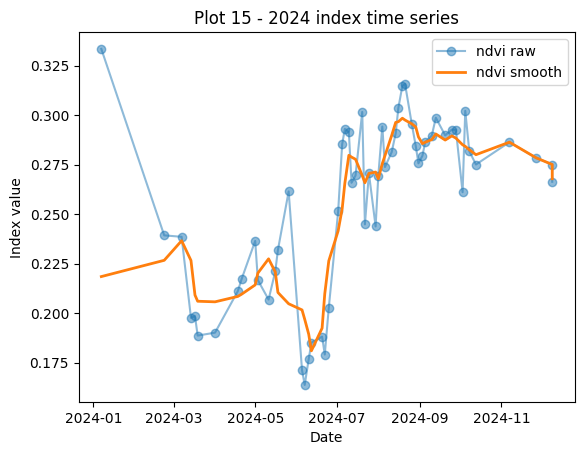

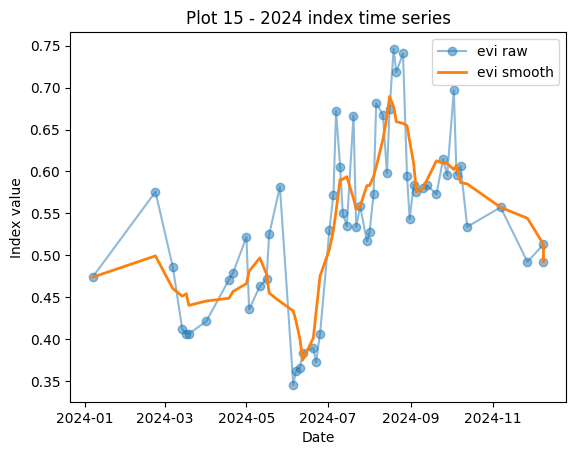

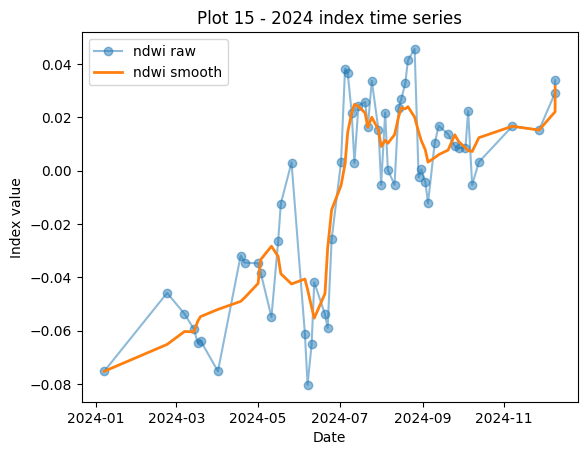

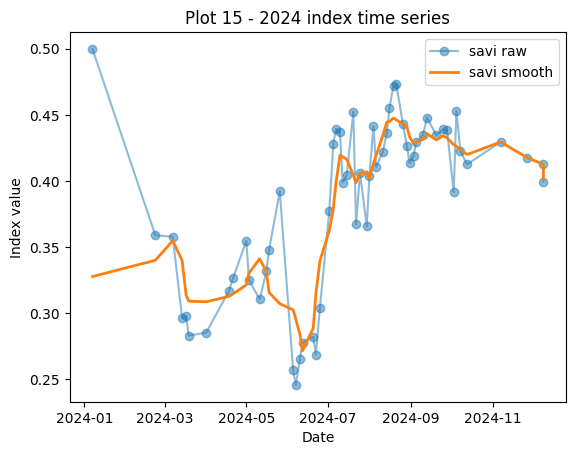

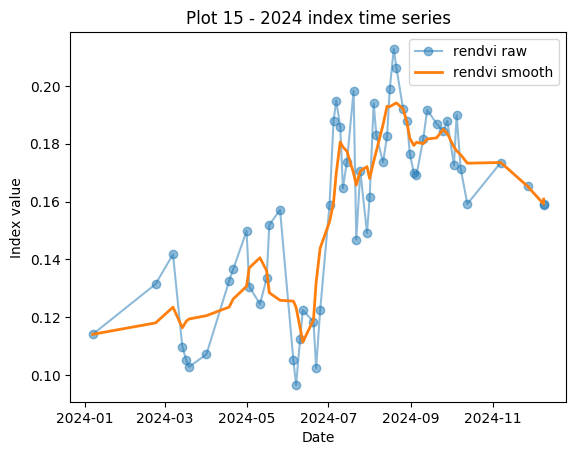

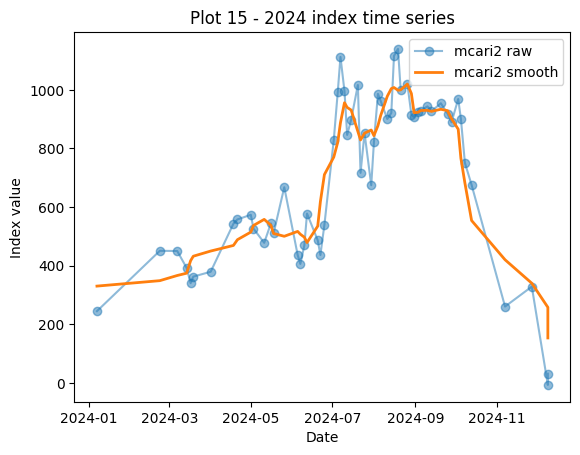

In [14]:
plot_id = 15    # example plot
year = 2024    # example year

df_plot = df[(df['plot_id']==plot_id) & (df['date'].dt.year==year)].sort_values('date')

indices = ['ndvi','evi','ndwi','savi','rendvi','mcari2']

# plt.figure(figsize=(14,6))
for idx in indices:
    plt.plot(df_plot['date'], df_plot[idx], 'o-', alpha=0.5, label=f'{idx} raw')
    sm = idx + '_smooth'
    if sm in df_plot.columns:
        plt.plot(df_plot['date'], df_plot[sm], '-', lw=2, label=f'{idx} smooth')
    plt.title(f'Plot {plot_id} - {year} index time series')
    plt.xlabel('Date')
    plt.ylabel('Index value')
    plt.legend()
    plt.show()


In [15]:
veg_features = ['ndvi_smooth', 'evi_smooth', 'ndwi_smooth', 'savi_smooth', 'rendvi_smooth', 'mcari2_smooth']

df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.week

In [16]:
df_orig = df.copy()
df = df.copy()

In [17]:
df = df_orig.copy()

In [18]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,year,ndvi_residual,ndvi_residual_pct,evi_residual,evi_residual_pct,ndwi_residual,ndwi_residual_pct,savi_residual,savi_residual_pct,rendvi_residual,rendvi_residual_pct,mcari2_residual,mcari2_residual_pct,month,week
0,2016-02-08,0,0.218413,0.441113,0.023013,0.327557,0.126218,315.478035,0.304797,0.637747,0.025309,0.457125,0.179671,812.677581,2016,-0.086383,-0.283413,-0.196634,-0.308326,-0.002295,-0.090696,-0.129568,-0.283442,-0.053454,-0.297508,-497.199547,-0.611804,2,6
1,2016-04-08,0,0.332460,0.719258,0.070016,0.498614,0.200342,791.428357,0.344884,0.715000,0.070016,0.517252,0.210279,1026.807626,2016,-0.012425,-0.036026,0.004258,0.005955,0.000000,0.000000,-0.018638,-0.036032,-0.009938,-0.047259,-235.379270,-0.229234,4,14
2,2016-04-25,0,0.363517,0.752870,0.086059,0.545204,0.212455,991.572095,0.384116,0.807343,0.086059,0.576096,0.245371,1394.778824,2016,-0.020599,-0.053628,-0.054473,-0.067472,0.000000,0.000000,-0.030892,-0.053623,-0.032916,-0.134149,-403.206729,-0.289083,4,17
3,2016-05-08,0,0.408306,0.854081,0.084318,0.612377,0.265595,1152.231838,0.408306,0.854081,0.084318,0.612377,0.265595,1608.480912,2016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-456.249074,-0.283652,5,18
4,2016-05-28,0,0.465148,0.946759,0.070016,0.697634,0.302103,1883.327808,0.458689,0.965707,0.082003,0.687947,0.304792,1958.900316,2016,0.006459,0.014082,-0.018948,-0.019621,-0.011986,-0.146171,0.009687,0.014081,-0.002689,-0.008821,-75.572508,-0.038579,5,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28725,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.352118,0.792014,0.016670,0.528108,0.217763,971.908163,2024,0.020399,0.057932,-0.078634,-0.099283,-0.007804,-0.468142,0.030593,0.057929,0.011960,0.054920,160.695421,0.165340,10,41
28726,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.356482,0.757642,0.016104,0.534650,0.217073,782.366905,2024,0.007571,0.021238,-0.101745,-0.134291,-0.011081,-0.688086,0.011359,0.021246,-0.028263,-0.130200,60.755752,0.077656,11,45
28727,2024-11-27,64,0.260295,0.824603,0.000976,0.390374,0.157318,524.747433,0.343231,0.750294,0.016523,0.514776,0.204643,656.014303,2024,-0.082936,-0.241633,0.074309,0.099040,-0.015547,-0.940925,-0.124401,-0.241661,-0.047325,-0.231257,-131.266870,-0.200098,11,48
28728,2024-12-09,64,0.332288,0.731293,0.040914,0.498362,0.191950,85.399354,0.332288,0.731293,0.021304,0.498362,0.191950,539.137548,2024,0.000000,0.000000,0.000000,0.000000,0.019610,0.920480,0.000000,0.000000,0.000000,0.000000,-453.738194,-0.841600,12,50


In [19]:
df

,date,plot_id,ndvi,evi,ndwi,savi,rendvi,mcari2,ndvi_smooth,evi_smooth,ndwi_smooth,savi_smooth,rendvi_smooth,mcari2_smooth,year,ndvi_residual,ndvi_residual_pct,evi_residual,evi_residual_pct,ndwi_residual,ndwi_residual_pct,savi_residual,savi_residual_pct,rendvi_residual,rendvi_residual_pct,mcari2_residual,mcari2_residual_pct,month,week
0,2016-02-08,0,0.218413,0.441113,0.023013,0.327557,0.126218,315.478035,0.304797,0.637747,0.025309,0.457125,0.179671,812.677581,2016,-0.086383,-0.283413,-0.196634,-0.308326,-0.002295,-0.090696,-0.129568,-0.283442,-0.053454,-0.297508,-497.199547,-0.611804,2,6
1,2016-04-08,0,0.332460,0.719258,0.070016,0.498614,0.200342,791.428357,0.344884,0.715000,0.070016,0.517252,0.210279,1026.807626,2016,-0.012425,-0.036026,0.004258,0.005955,0.000000,0.000000,-0.018638,-0.036032,-0.009938,-0.047259,-235.379270,-0.229234,4,14
2,2016-04-25,0,0.363517,0.752870,0.086059,0.545204,0.212455,991.572095,0.384116,0.807343,0.086059,0.576096,0.245371,1394.778824,2016,-0.020599,-0.053628,-0.054473,-0.067472,0.000000,0.000000,-0.030892,-0.053623,-0.032916,-0.134149,-403.206729,-0.289083,4,17
3,2016-05-08,0,0.408306,0.854081,0.084318,0.612377,0.265595,1152.231838,0.408306,0.854081,0.084318,0.612377,0.265595,1608.480912,2016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-456.249074,-0.283652,5,18
4,2016-05-28,0,0.465148,0.946759,0.070016,0.697634,0.302103,1883.327808,0.458689,0.965707,0.082003,0.687947,0.304792,1958.900316,2016,0.006459,0.014082,-0.018948,-0.019621,-0.011986,-0.146171,0.009687,0.014081,-0.002689,-0.008821,-75.572508,-0.038579,5,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28725,2024-10-13,64,0.372517,0.713380,0.008866,0.558701,0.229722,1132.603585,0.352118,0.792014,0.016670,0.528108,0.217763,971.908163,2024,0.020399,0.057932,-0.078634,-0.099283,-0.007804,-0.468142,0.030593,0.057929,0.011960,0.054920,160.695421,0.165340,10,41
28726,2024-11-07,64,0.364053,0.655897,0.005023,0.546009,0.188810,843.122656,0.356482,0.757642,0.016104,0.534650,0.217073,782.366905,2024,0.007571,0.021238,-0.101745,-0.134291,-0.011081,-0.688086,0.011359,0.021246,-0.028263,-0.130200,60.755752,0.077656,11,45
28727,2024-11-27,64,0.260295,0.824603,0.000976,0.390374,0.157318,524.747433,0.343231,0.750294,0.016523,0.514776,0.204643,656.014303,2024,-0.082936,-0.241633,0.074309,0.099040,-0.015547,-0.940925,-0.124401,-0.241661,-0.047325,-0.231257,-131.266870,-0.200098,11,48
28728,2024-12-09,64,0.332288,0.731293,0.040914,0.498362,0.191950,85.399354,0.332288,0.731293,0.021304,0.498362,0.191950,539.137548,2024,0.000000,0.000000,0.000000,0.000000,0.019610,0.920480,0.000000,0.000000,0.000000,0.000000,-453.738194,-0.841600,12,50


In [20]:
def stretch_to_daily_per_year(g):
    # g is all data for one plot_id
    daily_parts = []
    for year, g_year in g.groupby(g['date'].dt.year):
        g_year = g_year.copy()
        numeric_cols = g_year.select_dtypes(include=[np.number]).columns.tolist()
        if 'date' in numeric_cols:
            numeric_cols.remove('date')
        
        # Collapse duplicate dates
        g_year = (g_year.groupby('date')
                  .agg({**{c: 'mean' for c in numeric_cols},
                        **{c: 'first' for c in g_year.columns.difference(numeric_cols + ['date'])}})
                  .reset_index()
                 )
        
        g_year = g_year.set_index('date').sort_index()
        full_idx = pd.date_range(start=g_year.index.min(), end=g_year.index.max(), freq='D')
        g_year = g_year.reindex(full_idx)
        
        g_year['plot_id'] = g_year['plot_id'].ffill().bfill()
        for col in numeric_cols:
            g_year[col] = g_year[col].interpolate(method='time', limit_direction='both')
        
        non_numeric = [c for c in g_year.columns if c not in numeric_cols + ['plot_id']]
        if non_numeric:
            g_year[non_numeric] = g_year[non_numeric].ffill().bfill()
        
        g_year = g_year.reset_index().rename(columns={'index':'date'})
        daily_parts.append(g_year)
    
    return pd.concat(daily_parts, axis=0)


In [21]:
full_daily = df.groupby('plot_id', as_index=False).apply(lambda g: stretch_to_daily_per_year(g)).reset_index(drop=True)


In [22]:
full_daily['week'] = full_daily['date'].dt.week

In [23]:
weekly_stats_list = []

for (plot, year, week), group in tqdm(full_daily.groupby([full_daily['plot_id'], full_daily['date'].dt.year, full_daily['date'].dt.week])):
    week_dict = {'plot_id': plot, 'year': year, 'week': week}
    
    # convert dates to numeric ordinals for slope calculation
    x = group['date'].map(pd.Timestamp.toordinal).values
    
    for feat in veg_features:
        y = group[feat].values
        
        # compute slope (direction matters)
        week_dict[f'{feat}_slope'] = np.polyfit(x, y, 1)[0] if len(x) > 1 else np.nan
        
        # compute weekly summary statistics
        week_dict[f'{feat}_mean'] = np.mean(y)
        week_dict[f'{feat}_std']  = np.std(y)
        week_dict[f'{feat}_max']  = np.max(y)
        week_dict[f'{feat}_min']  = np.min(y)
    
    weekly_stats_list.append(week_dict)

weekly_stats_df = pd.DataFrame(weekly_stats_list)


100%|████████████████████████████████████| 26195/26195 [00:46<00:00, 563.78it/s]


In [24]:
wsdf = weekly_stats_df.copy()
wsdf = wsdf[wsdf['week'].isin([str(i) for i in range(28, 45)])]

In [25]:
[col for col in wsdf.columns]

['plot_id',
 'year',
 'week',
 'ndvi_smooth_slope',
 'ndvi_smooth_mean',
 'ndvi_smooth_std',
 'ndvi_smooth_max',
 'ndvi_smooth_min',
 'evi_smooth_slope',
 'evi_smooth_mean',
 'evi_smooth_std',
 'evi_smooth_max',
 'evi_smooth_min',
 'ndwi_smooth_slope',
 'ndwi_smooth_mean',
 'ndwi_smooth_std',
 'ndwi_smooth_max',
 'ndwi_smooth_min',
 'savi_smooth_slope',
 'savi_smooth_mean',
 'savi_smooth_std',
 'savi_smooth_max',
 'savi_smooth_min',
 'rendvi_smooth_slope',
 'rendvi_smooth_mean',
 'rendvi_smooth_std',
 'rendvi_smooth_max',
 'rendvi_smooth_min',
 'mcari2_smooth_slope',
 'mcari2_smooth_mean',
 'mcari2_smooth_std',
 'mcari2_smooth_max',
 'mcari2_smooth_min']

In [26]:
veg_agg = wsdf.copy() 

In [27]:
drop_cols = [col for col in veg_agg.columns if 'max' in col or 'min' in col]

In [28]:
veg_agg = veg_agg.drop(columns = drop_cols)

In [29]:
veg_agg

,plot_id,year,week,ndvi_smooth_slope,ndvi_smooth_mean,ndvi_smooth_std,evi_smooth_slope,evi_smooth_mean,evi_smooth_std,ndwi_smooth_slope,ndwi_smooth_mean,ndwi_smooth_std,savi_smooth_slope,savi_smooth_mean,savi_smooth_std,rendvi_smooth_slope,rendvi_smooth_mean,rendvi_smooth_std,mcari2_smooth_slope,mcari2_smooth_mean,mcari2_smooth_std
22,0.0,2016,28,0.001427,0.492664,0.002952,0.003504,1.041574,0.007293,-0.000038,0.082350,0.000090,0.002141,0.738904,0.004428,0.001474,0.335455,0.003077,19.222501,2245.977409,40.922093
23,0.0,2016,29,0.002158,0.506519,0.004316,0.005465,1.076468,0.010930,-0.000085,0.081834,0.000171,0.003237,0.759684,0.006474,0.002328,0.350286,0.004655,32.833426,2452.478375,65.666851
24,0.0,2016,30,-0.000958,0.514245,0.002500,-0.003695,1.095472,0.009211,-0.000859,0.080625,0.001888,-0.001436,0.771271,0.003750,-0.000583,0.361157,0.002287,-3.864695,2671.805419,43.784911
25,0.0,2016,31,-0.001603,0.502695,0.003214,-0.004570,1.055686,0.009286,-0.000954,0.072686,0.001925,-0.002404,0.753947,0.004820,-0.001328,0.351231,0.002675,-19.857031,2517.367999,40.348046
26,0.0,2016,32,-0.001454,0.492293,0.002908,-0.003528,1.029425,0.007057,-0.000794,0.066887,0.001588,-0.002181,0.738345,0.004362,-0.001128,0.343034,0.002256,-15.351122,2403.151279,30.702245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26184,64.0,2024,40,-0.005021,0.404334,0.010284,-0.009540,0.850357,0.019449,-0.002624,0.030651,0.005313,-0.007532,0.606428,0.015425,-0.005885,0.268185,0.012077,-62.681171,1626.467746,128.764579
26185,64.0,2024,41,-0.003656,0.361953,0.007521,-0.003811,0.803124,0.007638,-0.000431,0.017590,0.001037,-0.005484,0.542860,0.011281,-0.003424,0.227202,0.006969,-57.623517,1140.286406,115.456973
26186,64.0,2024,42,0.000175,0.352816,0.000349,-0.001375,0.786514,0.002750,-0.000023,0.016580,0.000045,0.000262,0.529155,0.000523,-0.000028,0.217652,0.000055,-7.581650,941.581562,15.163301
26187,64.0,2024,43,0.000175,0.354038,0.000349,-0.001375,0.776890,0.002750,-0.000023,0.016421,0.000045,0.000262,0.530987,0.000523,-0.000028,0.217459,0.000055,-7.581650,888.510010,15.163301


In [30]:
slope_cols = [c for c in veg_agg.columns if c.endswith('_slope')]
std_cols = [c for c in veg_agg.columns if c.endswith('_std')]

veg_agg[slope_cols] = veg_agg[slope_cols].fillna(0)
veg_agg[std_cols] = veg_agg[std_cols].fillna(0)


In [31]:
# Pivot so that each month becomes a set of columns
veg_agg_wide = veg_agg.pivot_table(
    index=['plot_id','year'],
    columns='week',
    values=[col for col in veg_agg.columns if col not in ['plot_id','year','week']]
).reset_index()

# Flatten multi-index columns
veg_agg_wide.columns = ['_'.join([str(c) for c in col if c != '']) for col in veg_agg_wide.columns]


In [32]:
veg_agg_wide

,plot_id,year,evi_smooth_mean_28,evi_smooth_mean_29,evi_smooth_mean_30,evi_smooth_mean_31,evi_smooth_mean_32,evi_smooth_mean_33,evi_smooth_mean_34,evi_smooth_mean_35,evi_smooth_mean_36,evi_smooth_mean_37,evi_smooth_mean_38,evi_smooth_mean_39,evi_smooth_mean_40,evi_smooth_mean_41,evi_smooth_mean_42,evi_smooth_mean_43,evi_smooth_mean_44,evi_smooth_slope_28,evi_smooth_slope_29,evi_smooth_slope_30,evi_smooth_slope_31,evi_smooth_slope_32,evi_smooth_slope_33,evi_smooth_slope_34,evi_smooth_slope_35,evi_smooth_slope_36,evi_smooth_slope_37,evi_smooth_slope_38,evi_smooth_slope_39,evi_smooth_slope_40,evi_smooth_slope_41,evi_smooth_slope_42,evi_smooth_slope_43,evi_smooth_slope_44,evi_smooth_std_28,evi_smooth_std_29,evi_smooth_std_30,evi_smooth_std_31,evi_smooth_std_32,evi_smooth_std_33,evi_smooth_std_34,evi_smooth_std_35,evi_smooth_std_36,evi_smooth_std_37,evi_smooth_std_38,evi_smooth_std_39,evi_smooth_std_40,evi_smooth_std_41,evi_smooth_std_42,evi_smooth_std_43,evi_smooth_std_44,mcari2_smooth_mean_28,mcari2_smooth_mean_29,mcari2_smooth_mean_30,mcari2_smooth_mean_31,mcari2_smooth_mean_32,mcari2_smooth_mean_33,mcari2_smooth_mean_34,mcari2_smooth_mean_35,mcari2_smooth_mean_36,mcari2_smooth_mean_37,mcari2_smooth_mean_38,mcari2_smooth_mean_39,mcari2_smooth_mean_40,mcari2_smooth_mean_41,mcari2_smooth_mean_42,mcari2_smooth_mean_43,mcari2_smooth_mean_44,mcari2_smooth_slope_28,mcari2_smooth_slope_29,mcari2_smooth_slope_30,mcari2_smooth_slope_31,mcari2_smooth_slope_32,mcari2_smooth_slope_33,mcari2_smooth_slope_34,mcari2_smooth_slope_35,mcari2_smooth_slope_36,mcari2_smooth_slope_37,mcari2_smooth_slope_38,mcari2_smooth_slope_39,mcari2_smooth_slope_40,mcari2_smooth_slope_41,mcari2_smooth_slope_42,mcari2_smooth_slope_43,mcari2_smooth_slope_44,mcari2_smooth_std_28,mcari2_smooth_std_29,mcari2_smooth_std_30,mcari2_smooth_std_31,mcari2_smooth_std_32,mcari2_smooth_std_33,mcari2_smooth_std_34,mcari2_smooth_std_35,mcari2_smooth_std_36,mcari2_smooth_std_37,mcari2_smooth_std_38,mcari2_smooth_std_39,mcari2_smooth_std_40,mcari2_smooth_std_41,mcari2_smooth_std_42,mcari2_smooth_std_43,mcari2_smooth_std_44,ndvi_smooth_mean_28,ndvi_smooth_mean_29,ndvi_smooth_mean_30,ndvi_smooth_mean_31,ndvi_smooth_mean_32,ndvi_smooth_mean_33,ndvi_smooth_mean_34,ndvi_smooth_mean_35,ndvi_smooth_mean_36,ndvi_smooth_mean_37,ndvi_smooth_mean_38,ndvi_smooth_mean_39,ndvi_smooth_mean_40,ndvi_smooth_mean_41,ndvi_smooth_mean_42,ndvi_smooth_mean_43,ndvi_smooth_mean_44,ndvi_smooth_slope_28,ndvi_smooth_slope_29,ndvi_smooth_slope_30,ndvi_smooth_slope_31,ndvi_smooth_slope_32,ndvi_smooth_slope_33,ndvi_smooth_slope_34,ndvi_smooth_slope_35,ndvi_smooth_slope_36,ndvi_smooth_slope_37,ndvi_smooth_slope_38,ndvi_smooth_slope_39,ndvi_smooth_slope_40,ndvi_smooth_slope_41,ndvi_smooth_slope_42,ndvi_smooth_slope_43,ndvi_smooth_slope_44,ndvi_smooth_std_28,ndvi_smooth_std_29,ndvi_smooth_std_30,ndvi_smooth_std_31,ndvi_smooth_std_32,ndvi_smooth_std_33,ndvi_smooth_std_34,ndvi_smooth_std_35,ndvi_smooth_std_36,ndvi_smooth_std_37,ndvi_smooth_std_38,ndvi_smooth_std_39,ndvi_smooth_std_40,ndvi_smooth_std_41,ndvi_smooth_std_42,ndvi_smooth_std_43,ndvi_smooth_std_44,ndwi_smooth_mean_28,ndwi_smooth_mean_29,ndwi_smooth_mean_30,ndwi_smooth_mean_31,ndwi_smooth_mean_32,ndwi_smooth_mean_33,ndwi_smooth_mean_34,ndwi_smooth_mean_35,ndwi_smooth_mean_36,ndwi_smooth_mean_37,ndwi_smooth_mean_38,ndwi_smooth_mean_39,ndwi_smooth_mean_40,ndwi_smooth_mean_41,ndwi_smooth_mean_42,ndwi_smooth_mean_43,ndwi_smooth_mean_44,ndwi_smooth_slope_28,ndwi_smooth_slope_29,ndwi_smooth_slope_30,ndwi_smooth_slope_31,ndwi_smooth_slope_32,ndwi_smooth_slope_33,ndwi_smooth_slope_34,ndwi_smooth_slope_35,ndwi_smooth_slope_36,ndwi_smooth_slope_37,ndwi_smooth_slope_38,ndwi_smooth_slope_39,ndwi_smooth_slope_40,ndwi_smooth_slope_41,ndwi_smooth_slope_42,ndwi_smooth_slope_43,ndwi_smooth_slope_44,ndwi_smooth_std_28,ndwi_smooth_std_29,ndwi_smooth_std_30,ndwi_smooth_std_31,ndwi_smooth_std_32,ndwi_smooth_std_33,ndwi_smooth_std_34,ndwi_smooth_std_35,ndwi_smooth_std_36,ndwi_sm

In [33]:
[i for i in veg_agg_wide.columns if 'smooth' not in i]

['plot_id', 'year']

In [34]:
veg_agg_wide

,plot_id,year,evi_smooth_mean_28,evi_smooth_mean_29,evi_smooth_mean_30,evi_smooth_mean_31,evi_smooth_mean_32,evi_smooth_mean_33,evi_smooth_mean_34,evi_smooth_mean_35,evi_smooth_mean_36,evi_smooth_mean_37,evi_smooth_mean_38,evi_smooth_mean_39,evi_smooth_mean_40,evi_smooth_mean_41,evi_smooth_mean_42,evi_smooth_mean_43,evi_smooth_mean_44,evi_smooth_slope_28,evi_smooth_slope_29,evi_smooth_slope_30,evi_smooth_slope_31,evi_smooth_slope_32,evi_smooth_slope_33,evi_smooth_slope_34,evi_smooth_slope_35,evi_smooth_slope_36,evi_smooth_slope_37,evi_smooth_slope_38,evi_smooth_slope_39,evi_smooth_slope_40,evi_smooth_slope_41,evi_smooth_slope_42,evi_smooth_slope_43,evi_smooth_slope_44,evi_smooth_std_28,evi_smooth_std_29,evi_smooth_std_30,evi_smooth_std_31,evi_smooth_std_32,evi_smooth_std_33,evi_smooth_std_34,evi_smooth_std_35,evi_smooth_std_36,evi_smooth_std_37,evi_smooth_std_38,evi_smooth_std_39,evi_smooth_std_40,evi_smooth_std_41,evi_smooth_std_42,evi_smooth_std_43,evi_smooth_std_44,mcari2_smooth_mean_28,mcari2_smooth_mean_29,mcari2_smooth_mean_30,mcari2_smooth_mean_31,mcari2_smooth_mean_32,mcari2_smooth_mean_33,mcari2_smooth_mean_34,mcari2_smooth_mean_35,mcari2_smooth_mean_36,mcari2_smooth_mean_37,mcari2_smooth_mean_38,mcari2_smooth_mean_39,mcari2_smooth_mean_40,mcari2_smooth_mean_41,mcari2_smooth_mean_42,mcari2_smooth_mean_43,mcari2_smooth_mean_44,mcari2_smooth_slope_28,mcari2_smooth_slope_29,mcari2_smooth_slope_30,mcari2_smooth_slope_31,mcari2_smooth_slope_32,mcari2_smooth_slope_33,mcari2_smooth_slope_34,mcari2_smooth_slope_35,mcari2_smooth_slope_36,mcari2_smooth_slope_37,mcari2_smooth_slope_38,mcari2_smooth_slope_39,mcari2_smooth_slope_40,mcari2_smooth_slope_41,mcari2_smooth_slope_42,mcari2_smooth_slope_43,mcari2_smooth_slope_44,mcari2_smooth_std_28,mcari2_smooth_std_29,mcari2_smooth_std_30,mcari2_smooth_std_31,mcari2_smooth_std_32,mcari2_smooth_std_33,mcari2_smooth_std_34,mcari2_smooth_std_35,mcari2_smooth_std_36,mcari2_smooth_std_37,mcari2_smooth_std_38,mcari2_smooth_std_39,mcari2_smooth_std_40,mcari2_smooth_std_41,mcari2_smooth_std_42,mcari2_smooth_std_43,mcari2_smooth_std_44,ndvi_smooth_mean_28,ndvi_smooth_mean_29,ndvi_smooth_mean_30,ndvi_smooth_mean_31,ndvi_smooth_mean_32,ndvi_smooth_mean_33,ndvi_smooth_mean_34,ndvi_smooth_mean_35,ndvi_smooth_mean_36,ndvi_smooth_mean_37,ndvi_smooth_mean_38,ndvi_smooth_mean_39,ndvi_smooth_mean_40,ndvi_smooth_mean_41,ndvi_smooth_mean_42,ndvi_smooth_mean_43,ndvi_smooth_mean_44,ndvi_smooth_slope_28,ndvi_smooth_slope_29,ndvi_smooth_slope_30,ndvi_smooth_slope_31,ndvi_smooth_slope_32,ndvi_smooth_slope_33,ndvi_smooth_slope_34,ndvi_smooth_slope_35,ndvi_smooth_slope_36,ndvi_smooth_slope_37,ndvi_smooth_slope_38,ndvi_smooth_slope_39,ndvi_smooth_slope_40,ndvi_smooth_slope_41,ndvi_smooth_slope_42,ndvi_smooth_slope_43,ndvi_smooth_slope_44,ndvi_smooth_std_28,ndvi_smooth_std_29,ndvi_smooth_std_30,ndvi_smooth_std_31,ndvi_smooth_std_32,ndvi_smooth_std_33,ndvi_smooth_std_34,ndvi_smooth_std_35,ndvi_smooth_std_36,ndvi_smooth_std_37,ndvi_smooth_std_38,ndvi_smooth_std_39,ndvi_smooth_std_40,ndvi_smooth_std_41,ndvi_smooth_std_42,ndvi_smooth_std_43,ndvi_smooth_std_44,ndwi_smooth_mean_28,ndwi_smooth_mean_29,ndwi_smooth_mean_30,ndwi_smooth_mean_31,ndwi_smooth_mean_32,ndwi_smooth_mean_33,ndwi_smooth_mean_34,ndwi_smooth_mean_35,ndwi_smooth_mean_36,ndwi_smooth_mean_37,ndwi_smooth_mean_38,ndwi_smooth_mean_39,ndwi_smooth_mean_40,ndwi_smooth_mean_41,ndwi_smooth_mean_42,ndwi_smooth_mean_43,ndwi_smooth_mean_44,ndwi_smooth_slope_28,ndwi_smooth_slope_29,ndwi_smooth_slope_30,ndwi_smooth_slope_31,ndwi_smooth_slope_32,ndwi_smooth_slope_33,ndwi_smooth_slope_34,ndwi_smooth_slope_35,ndwi_smooth_slope_36,ndwi_smooth_slope_37,ndwi_smooth_slope_38,ndwi_smooth_slope_39,ndwi_smooth_slope_40,ndwi_smooth_slope_41,ndwi_smooth_slope_42,ndwi_smooth_slope_43,ndwi_smooth_slope_44,ndwi_smooth_std_28,ndwi_smooth_std_29,ndwi_smooth_std_30,ndwi_smooth_std_31,ndwi_smooth_std_32,ndwi_smooth_std_33,ndwi_smooth_std_34,ndwi_smooth_std_35,ndwi_smooth_std_36,ndwi_sm

In [35]:
veg_agg_wide.to_pickle('data/ndvi/plots/final_df.pkl')